### Perform one-way ANOVA hypothesis test on the data

In [1]:
import numpy as np
import pandas as pd

import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data/salaries.csv')

In [3]:
data_remote = data[['salary_in_usd', 'remote_ratio']]

In [4]:
data_remote.head()

,salary_in_usd,remote_ratio
0,65013,100
1,165000,100
2,100000,100
3,225000,50
4,113262,100


In [5]:
groups = data_remote.groupby('remote_ratio').count().reset_index()
groups

,remote_ratio,salary_in_usd
0,0,18
1,50,725
2,100,1708


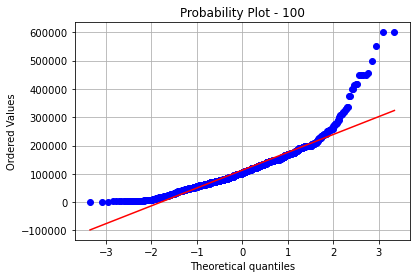

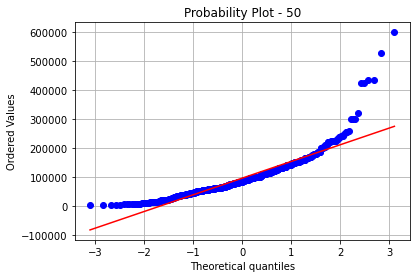

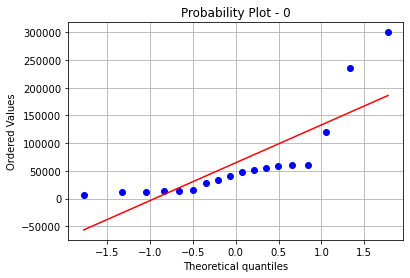

In [6]:
unique_ratios = data_remote['remote_ratio'].unique()

for ratio in unique_ratios:
    stats.probplot(data_remote[data_remote['remote_ratio'] == ratio]['salary_in_usd'], dist="norm", plot=plt)
    plt.title("Probability Plot - " +  str(ratio))
    plt.grid()
    plt.show()

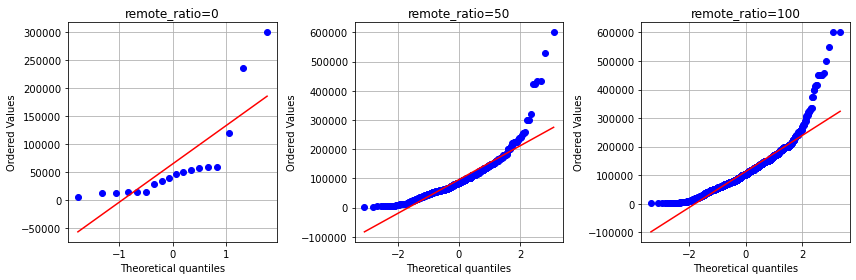

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

res1 = stats.probplot(data_remote[data_remote['remote_ratio'] == 0]['salary_in_usd'], dist="norm", plot=ax1)
res2 = stats.probplot(data_remote[data_remote['remote_ratio'] == 50]['salary_in_usd'], dist="norm", plot=ax2)
res3 = stats.probplot(data_remote[data_remote['remote_ratio'] == 100]['salary_in_usd'], dist="norm", plot=ax3)

ax1.set_title("remote_ratio=0")
ax2.set_title("remote_ratio=50")
ax3.set_title("remote_ratio=100")

ax1.grid()
ax2.grid()
ax3.grid()

plt.tight_layout()

plt.savefig('probplot.pdf')

plt.show()

In [8]:
ratio = data_remote.groupby('remote_ratio').std().max() / data_remote.groupby('remote_ratio').std().min()
ratio

salary_in_usd    1.266254
dtype: float64

In [9]:
pd.set_option('display.float_format', '{:.5g}'.format)

In [10]:
# Create ANOVA backbone table
#data = [['Between Groups', '', '', ''], ['Within Groups', '', '', ''], ['Total', '', '', '']]
data = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']] 
anova_table = pd.DataFrame(data, columns = ['Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit']) 
anova_table.set_index('Source of Variation', inplace = True)

# calculate SSTR and update anova table
x_bar = data_remote['salary_in_usd'].mean()
SSTR = data_remote.groupby('remote_ratio').count() * (data_remote.groupby('remote_ratio').mean() - x_bar)**2
anova_table['SS']['Between Groups'] = SSTR['salary_in_usd'].sum()

# calculate SSE and update anova table
SSE = (data_remote.groupby('remote_ratio').count() - 1) * data_remote.groupby('remote_ratio').std()**2
anova_table['SS']['Within Groups'] = SSE['salary_in_usd'].sum()

# calculate SSTR and update anova table
SSTR = SSTR['salary_in_usd'].sum() + SSE['salary_in_usd'].sum()
anova_table['SS']['Total'] = SSTR

# update degree of freedom
anova_table['df']['Between Groups'] = data_remote['remote_ratio'].nunique() - 1
anova_table['df']['Within Groups'] = data_remote.shape[0] - data_remote['remote_ratio'].nunique()
anova_table['df']['Total'] = data_remote.shape[0] - 1

# calculate MS
anova_table['MS'] = anova_table['SS'] / anova_table['df']

# calculate F 
F = anova_table['MS']['Between Groups'] / anova_table['MS']['Within Groups']
anova_table['F']['Between Groups'] = F

# p-value
anova_table['P-value']['Between Groups'] = 1 - stats.f.cdf(F, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# F critical 
alpha = 0.05
# possible types "right-tailed, left-tailed, two-tailed"
tail_hypothesis_type = "two-tailed"
if tail_hypothesis_type == "two-tailed":
    alpha /= 2
anova_table['F crit']['Between Groups'] = stats.f.ppf(1-alpha, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# Final ANOVA Table
anova_table

,SS,df,MS,F,P-value,F crit
Source of Variation,,,,,,
Between Groups,1.7962e+11,2,8.9812e+10,20.884,1.0152e-09,3.6944
Within Groups,1.0527e+13,2448,4.3004e+09,,,
Total,1.0707e+13,2450,4.3702e+09,,,


In [11]:
# The p-value approach
print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
conclusion = "Failed to reject the null hypothesis."
if anova_table['P-value']['Between Groups'] <= alpha:
    conclusion = "Null Hypothesis is rejected."
print("F-score is:", anova_table['F']['Between Groups'], " and p value is:", anova_table['P-value']['Between Groups'])    
print(conclusion)
    
# The critical value approach
print("\n--------------------------------------------------------------------------------------")
print("Approach 2: The critical value approach to hypothesis testing in the decision rule")
conclusion = "Failed to reject the null hypothesis."
if anova_table['F']['Between Groups'] > anova_table['F crit']['Between Groups']:
    conclusion = "Null Hypothesis is rejected."
print("F-score is:", anova_table['F']['Between Groups'], " and critical value is:", anova_table['F crit']['Between Groups'])
print(conclusion)

Approach 1: The p-value approach to hypothesis testing in the decision rule
F-score is: 20.884370048998868  and p value is: 1.0151773865985092e-09
Null Hypothesis is rejected.

--------------------------------------------------------------------------------------
Approach 2: The critical value approach to hypothesis testing in the decision rule
F-score is: 20.884370048998868  and critical value is: 3.6944437973810498
Null Hypothesis is rejected.


(based on https://towardsdatascience.com/anova-test-with-python-cfbf4013328b0)